Skin Cancer Classification - An Educational Guide
=====================
In this tutorial we aim to provide a simple step-by-step guide to anyone who wants to work on the problem of skin lesion classification regardless of their level or expertise; from medical doctors, to master students and more experienced researchers.

## Using this guide you will learn:

- How to load the data, visualise it and uncover more about the class distribution and meta-data.
- How to utilise architectures with varying complexity from a few convolutional layers to hundreds of them.
- How to train a model with appropriate optimisers and loss functions.
- How to rigorously test your trained model, providing not only metrics such as accuracy but also visualisations like confusion matrix and Grad — Cam.
- How to analyse and understand your results.

To conclude with, we will provide a few more tips that are usually utilised by the participants of the ISIC Challenges, that will help you increase your model’s performance even more so that you can beat our performance and explore more advanced training schemes.

In [4]:
# !pip install imageio
# !pip install scikit-image
!ls
!pip install -r requirements.txt

README.md                      requirements.txt
SkinLesionClassification.ipynb
ERROR: Could not find a version that satisfies the requirement glob (from -r requirements.txt (line 11)) (from versions: none)
ERROR: No matching distribution found for glob (from -r requirements.txt (line 11))


In [5]:

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')


What about data?
----------------

The HAM10000 ("Human Against Machine with 10000 training images") dataset which contains 10,015 dermatoscopic images was made publically available by the Harvard database on June 2018 in the hopes to provide training data for automating the process of skin cancer lesion classifications. The motivation behind this act was to provide the public with an abundance and variability of data source for machine learning training purposes such that the results may be compared with that of human experts. If successful, the appplications would bring cost and time saving regimes to hospitals and medical professions alike.

Apart from the 10,015 images, a metadata file with demographic information of each lesion is provided as well. More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal)

You can download the dataset here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

The 7 classes of skin cancer lesions included in this dataset are:

1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma


#### Let's analyze the metadata of the dataset

In [17]:
# importing metadata and checking for its shape
%ls
data_dir =  "dataverse_files"

metadata = pd.read_csv(data_dir + '/HAM10000_metadata.csv')
print(metadata.shape)

# label encoding the seven classes for skin cancers

le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

README.md                       dataverse_files/
SkinLesionClassification.ipynb  requirements.txt
(10015, 8)
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
3633,HAM_0003207,ISIC_0024534,nv,follow_up,40.0,male,back,vidir_molemax,5
7418,HAM_0005571,ISIC_0032803,nv,histo,35.0,male,neck,vidir_modern,5
3965,HAM_0002102,ISIC_0024474,nv,follow_up,65.0,male,trunk,vidir_molemax,5
7340,HAM_0001484,ISIC_0032623,nv,histo,40.0,female,upper extremity,vidir_modern,5
3851,HAM_0001875,ISIC_0031231,nv,follow_up,40.0,female,lower extremity,vidir_molemax,5
6484,HAM_0000788,ISIC_0030301,nv,follow_up,35.0,female,trunk,vidir_molemax,5
3248,HAM_0001590,ISIC_0025722,nv,follow_up,50.0,male,lower extremity,vidir_molemax,5
2094,HAM_0002436,ISIC_0025127,mel,histo,60.0,male,upper extremity,rosendahl,4
1903,HAM_0005124,ISIC_0030150,mel,histo,80.0,female,neck,rosendahl,4
5702,HAM_0002743,ISIC_0030439,nv,follow_up,40.0,male,abdomen,vidir_molemax,5


In [40]:
import os
import shutil
%ls

# A path to the folder which has all the images:
data_dir = os.getcwd() + "/dataverse_files/"

# A path to the folder where you want to store the rearranged images:
dest_dir = os.getcwd() + "/HAM10K"

# Read the metadata file:
metadata = pd.read_csv(data_dir + '/HAM10000_metadata.csv')
label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
label_images = []

# Copy the images into new folder structure:
for i in label:
    print(i)
    #os.mkdir(dest_dir + str(i) + "/")
    sample = metadata[metadata['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        try:
            shutil.copyfile((data_dir + "HAM10000_images_part_1/" + id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
        except:
            try:
                shutil.copyfile((data_dir + "HAM10000_images_part_2/" + id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
            except:
                print("image not found")
            
    label_images=[] 

HAM10Kakiec/                    HAM10Kvasc/
HAM10Kbcc/                      README.md
HAM10Kbkl/                      SkinLesionClassification.ipynb
HAM10Kdf/                       dataverse_files/
HAM10Kmel/                      requirements.txt
HAM10Knv/
bkl
nv
df
mel
vasc
bcc
akiec


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


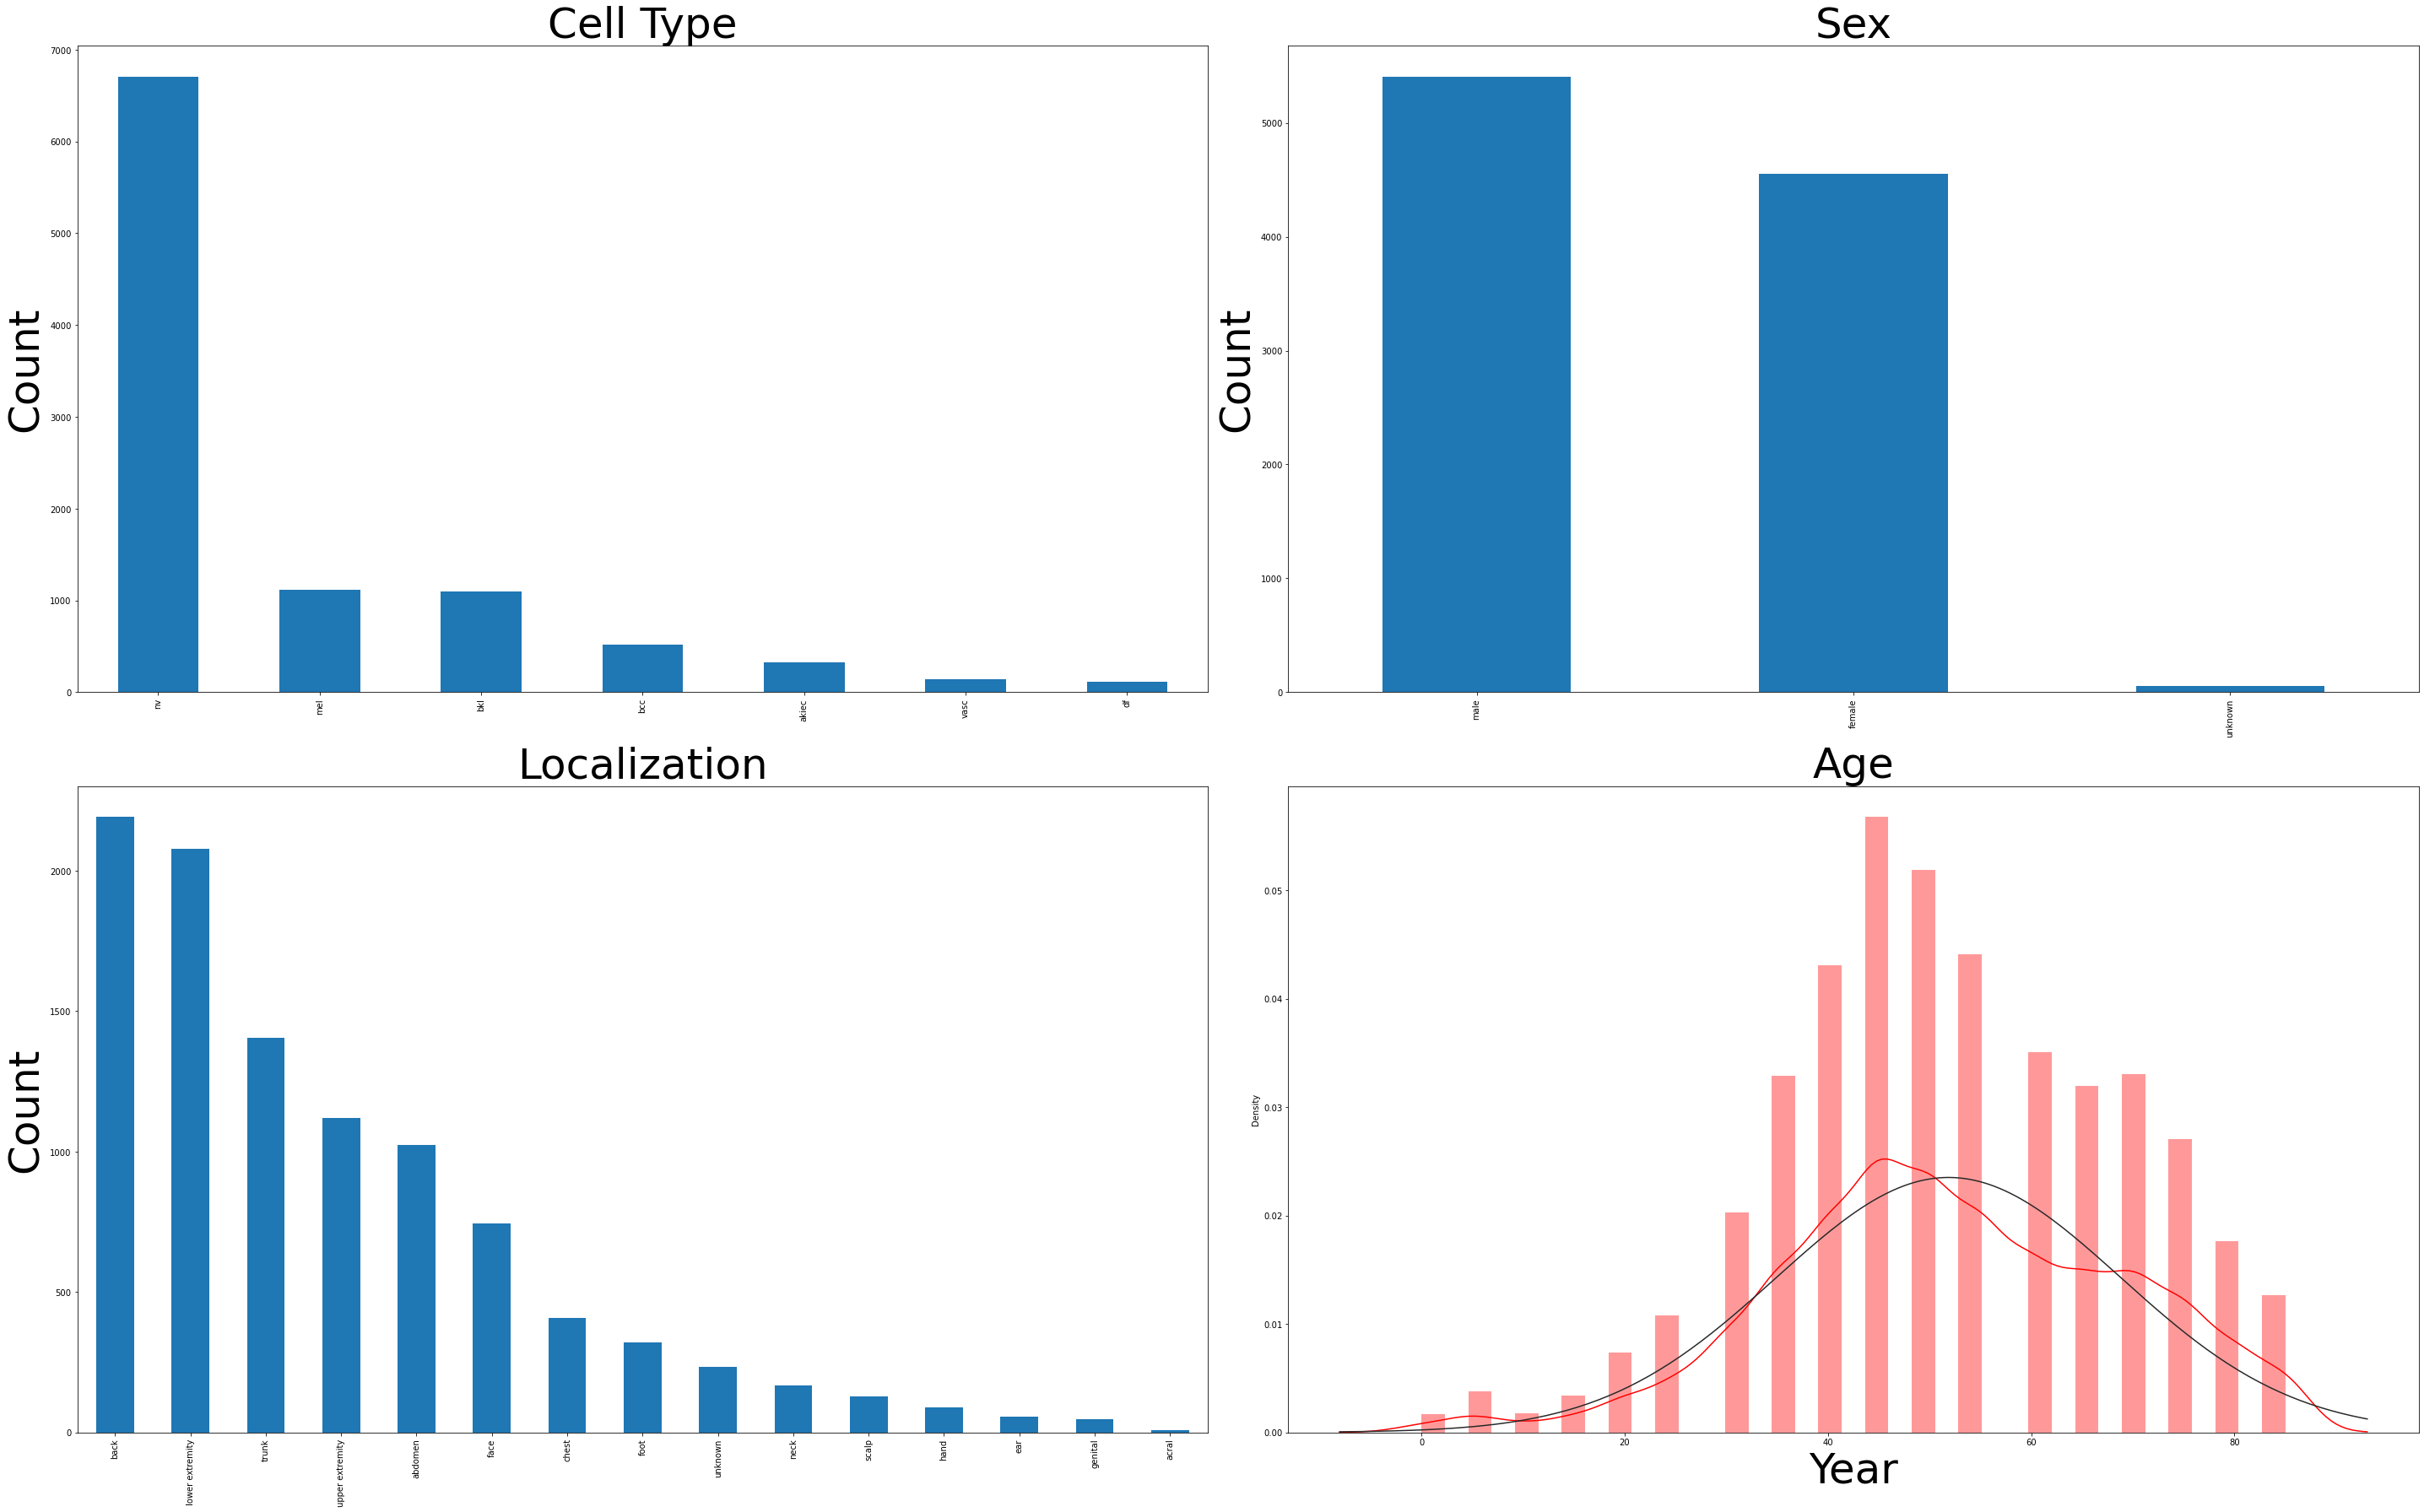

In [18]:
# Getting a sense of what the distribution of each column looks like

fig = plt.figure(figsize=(40,25))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=50)
ax1.set_title('Cell Type', size = 50)

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=50)
ax2.set_title('Sex', size=50);

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count', size=50)
ax3.set_title('Localization', size=50)


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age', size = 50)
ax4.set_xlabel('Year', size=50)

plt.tight_layout()
plt.show()

As you can see there is imbalance in the number of images per class. There  are much more images for the lesion type "Melanocytic Nevi" compared to other types. This is an usual occurence for medical datasets and so it is very important to analyze the data from beforehand.

#### Let's visualize some examples

In [41]:
#Visualizing the images

label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
label_images = []
classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']

fig = plt.figure(figsize=(55, 55))
k = range(7)

for i in label:
    sample = metadata[metadata['dx'] == i]['image_id'][:5]
    label_images.extend(sample)
    
for position,ID in enumerate(label_images):
    labl = metadata[metadata['image_id'] == ID]['dx']
    im_sample = data_dir + "/" + labl.values[0] + f'/{ID}.jpg'
    im_sample = imageio.imread(im_sample)

    plt.subplot(7,5,position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=50, weight="bold")

plt.tight_layout()
plt.show()

FileNotFoundError: No such file: '/Users/siddharthsaha/Desktop/SLClassificationAnEducationalCode-MEC2019-master/dataverse_files/akiec/ISIC_0029417.jpg'

<Figure size 3960x3960 with 0 Axes>

#### Median Frequency Balancing
As we saw above that there is class imbalance in our dataset. To solve that we use this method.

In [14]:
#print(metadata['dx'].value_counts())
#print(metadata[metadata['dx']=='nv']['dx'].value_counts())
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(np.float)
    #print(counts)
    median_freq = np.median(counts)
    #print(median_freq)
    #print(weights.shape)
    for i, label in enumerate(label):
        #print(label)
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight= estimate_weights_mfb(label)

for i in range(len(label)):
    print(label[i],":", classweight[i])


akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


<ipython-input-14-ee665294dfbc>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_weights = np.zeros_like(label, dtype=np.float)
<ipython-input-14-ee665294dfbc>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = counts.astype(np.float)


#### Pre-processing the dataset
Before we load the data we need to alter the dataset structure.
When you download the dataset, all the images are together in a folder. To use Pytorch dataloader we need to seggregrate the images into folders of their respetive labels. You can use the following script to automate the process.

In [7]:
# import os
# import shutil

# data_dir = os.getcwd() + "/HAM10000/"
# dest_dir = data_dir + "test/"
# metadata = pd.read_csv(data_dir + '/HAM10000_metadata.csv')

# label = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
# label_images = []

# for i in label:
#     os.mkdir(dest_dir + str(i) + "/")
#     sample = metadata[metadata['dx'] == i]['image_id'][:5]
#     label_images.extend(sample)
#     for id in label_images:
#         shutil.copyfile((data_dir + i + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
#     label_images=[]

#### Data Augmentation
It is a common fact that medical data is scarce. But to learn a very good model, the network needs a lot of data. So to tackle the problem we perform data augmentation.

First we normalize the images. Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. The distribution of such data would resemble a Gaussian curve centered at zero.
Since, skin lesion images are natural images, we use the normalization values (mean and standard deviation) of Imagenet dataset.

We also perform data augmentation:
- Flipping the image horizontally: *RandomHorizontalFlip()*
- Rotating image 60 degrees: *RandomRotation()* . 60 degrees is chosen as best practice. You can experiment with other angles.

The augmentation is applied using the *transform.Compose()* function of Pytorch.
Take note, we only augment the training set. This is because, augmentation is done to aid the training process. So there is no point in augmenting the test set.

In [15]:
data_dir = "/data/HAM10000"

# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 50
validation_batch_size = 10
test_batch_size = 10

# We compute the weights of individual classes and convert them to tensors
class_weights = estimate_weights_mfb(label)
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])


<ipython-input-14-ee665294dfbc>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_weights = np.zeros_like(label, dtype=np.float)
<ipython-input-14-ee665294dfbc>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = counts.astype(np.float)


## Train, Test and Validation Split

We split the entire dataset into 3 parts:
- Train: 80%
- Test: 20%
- Validation: 16%

The splitting is done class wise so that we have equal representation of all classes in each subset of the data.

In [9]:
import torch as th
import math

test_size = 0.2
val_size = 0.2
class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root= data_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))


Train Data Size: 6409
Test Data Size: 2003
Validation Data Size: 1603


Now we use Pytorch data loader to load the dataset into the memory.

In [13]:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)


NameError: name 'transform_train' is not defined

Let us see some of the training images.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


melanocytic nevi,  actinic keratoses,  benign keratosis-like lesions,  benign keratosis-like lesions,  melanocytic nevi,  melanocytic nevi,  basal cell carcinoma,  melanocytic nevi,  melanocytic nevi,  benign keratosis-like lesions,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  benign keratosis-like lesions,  melanocytic nevi,  melanoma,  melanocytic nevi,  melanocytic nevi,  melanoma,  melanoma,  melanocytic nevi,  actinic keratoses,  melanocytic nevi,  actinic keratoses,  melanocytic nevi,  melanocytic nevi,  melanoma,  melanocytic nevi,  melanoma,  melanoma,  melanocytic nevi,  melanoma,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanoma,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  dermatofibroma,  basal cell carcinoma,  basal cell carcinoma, 


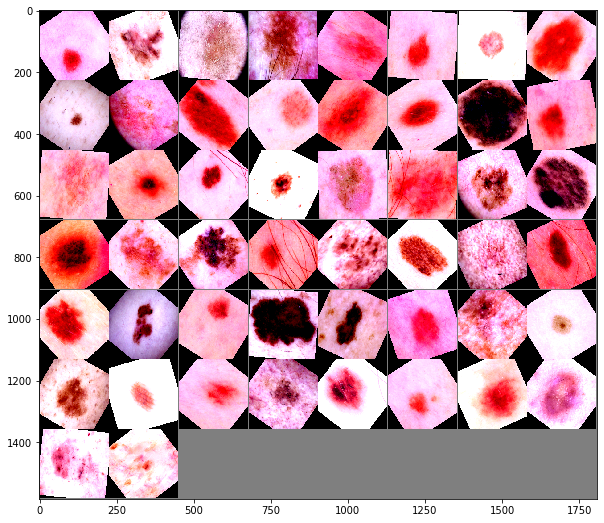

In [11]:
# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Define a Convolutional Neural Network

Pytorch makes it very easy to define a neural network. We have layers like Convolutions, ReLU non-linearity, Maxpooling etc. directly from torch library.

In this tutorial, we use The LeNet architecture introduced by LeCun et al. in their 1998 paper, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs.

In [12]:
num_classes = len(classes)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = LeNet()
net = net.to(device)

## Define a Loss function and Optimizer

Let's use a Classification Cross-Entropy loss.

$H_{y'} (y) := - \sum_{i} y_{i}' \log (y_i)$



The most common and effective Optimizer currently used is **Adam: Adaptive Moments**. You can look [here](https://arxiv.org/abs/1412.6980) for more information.


In [13]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


These are some helper functions to evaluate the training process.

In [14]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

## Train the network


This is when things start to get interesting.
We simply loop over the training data iterator, and feed the inputs to the
network and optimize.



In [15]:
# number of loops over the dataset
num_epochs = 50
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.806  Accuracy:0.314
Validation Loss: 1.727  Val Accuracy: 0.403
Epoch: 2
Loss: 1.663  Accuracy:0.371
Validation Loss: 1.631  Val Accuracy: 0.419
Epoch: 3
Loss: 1.589  Accuracy:0.459
Validation Loss: 1.565  Val Accuracy: 0.451
Epoch: 4
Loss: 1.542  Accuracy:0.486
Validation Loss: 1.558  Val Accuracy: 0.431
Epoch: 5
Loss: 1.499  Accuracy:0.494
Validation Loss: 1.483  Val Accuracy: 0.500
Epoch: 6
Loss: 1.472  Accuracy:0.500
Validation Loss: 1.457  Val Accuracy: 0.525
Epoch: 7
Loss: 1.447  Accuracy:0.509
Validation Loss: 1.454  Val Accuracy: 0.498
Epoch: 9
Loss: 1.421  Accuracy:0.503
Validation Loss: 1.406  Val Accuracy: 0.527
Epoch: 10
Loss: 1.399  Accuracy:0.516
Validation Loss: 1.413  Val Accuracy: 0.530
Epoch: 11
Loss: 1.390  Accuracy:0.519
Validation Loss: 1.436  Val Accuracy: 0.496
Epoch: 12
Loss: 1.384  Accuracy:0.519
Validation Loss: 1.396  Val Accuracy: 0.505
Epoch: 13
Loss: 1.373  Accuracy:0.529
Validation Loss: 1.391  Val Accuracy: 0.525
Epoch: 14
Loss: 1.363  A

Plot the training  and validation loss curves.

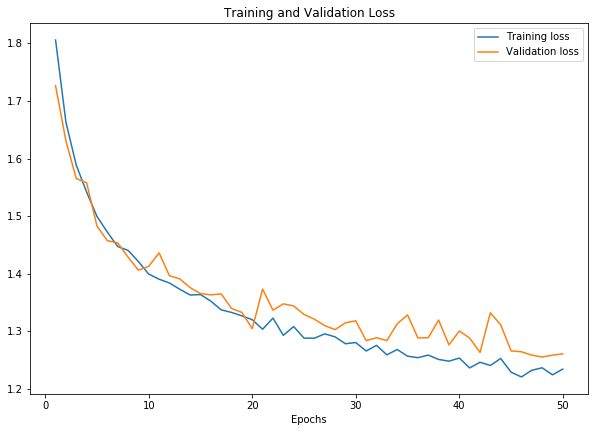

<Figure size 432x288 with 0 Axes>

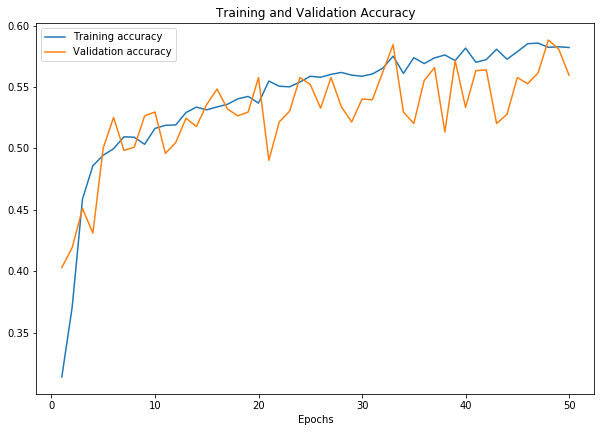

<Figure size 432x288 with 0 Axes>

In [16]:
# plt.plot(losses)
# plt.show()

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## Test the network on the test data

We have trained the network over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  melanocytic nevi,   benign keratosis-like lesions,   melanocytic nevi,   melanoma,   melanocytic nevi,   benign keratosis-like lesions,   melanocytic nevi,   melanoma,   benign keratosis-like lesions,   melanocytic nevi,  


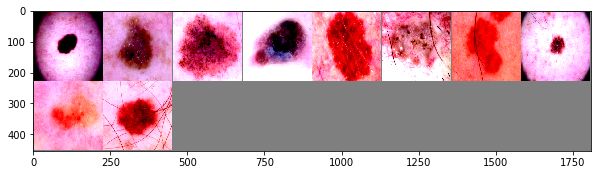

In [17]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

Okay, now let us check the performance on the test network:



In [18]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 52 %


That looks better than chance, which is about 14% accuracy (randomly picking
a class out of 7 classes).
Seems like the network learnt something. But maybe it doesn't learn all the classes equally.

Let's check which classes that performed well, and which did not.



In [19]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 27 %
Accuracy of basal cell carcinoma : 76 %
Accuracy of benign keratosis-like lesions :  4 %
Accuracy of dermatofibroma : 39 %
Accuracy of melanoma : 73 %
Accuracy of melanocytic nevi : 58 %
Accuracy of vascular lesions :  0 %


### Confusion Matrix

In [20]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()

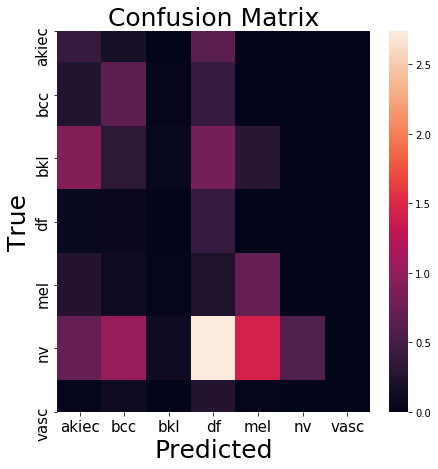

In [21]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);

### Grad cam

In [22]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

Generating Grad-CAM @conv2
	#0: melanocytic nevi (0.12183)


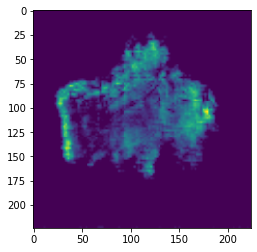

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  melanocytic nevi


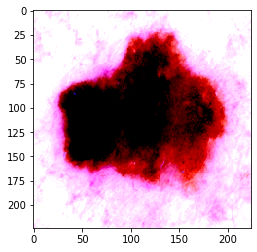

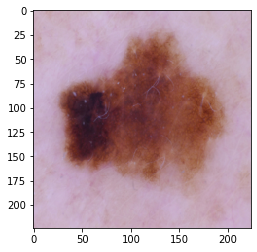

In [23]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["conv2"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()



## Analysis of the results

As we can see from the results of the LeNet model, our system is not capable of processing the complexity of the given input images. Our final accuracy on the test data was 61%. About 39% of the images are missclassified, which is a terrible performance for any clinical use case.

These results could be substantially improved if we opt for a deeper, more complex network architecture than LeNet, which will allow for a richer learning of the corresponding image features.


# Switching to superior network architecture:Resnet18

In [24]:
from torch import nn

num_classes = len(classes)
net = torchvision.models.resnet18(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

3. Define a Loss function and Optimizer

Let's use a Classification Cross-Entropy loss.

$H_{y'} (y) := - \sum_{i} y_{i}' \log (y_i)$



The most common and effective Optimizer currently used is **Adam: Adaptive Moments**. You can look [here](https://arxiv.org/abs/1412.6980) for more information.


In [25]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

These are some helper functions to evaluate the training process.

In [26]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

## Train the network


This is when things start to get interesting.
We simply loop over the training data iterator, and feed the inputs to the
network and optimize.



In [ ]:
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.918  Accuracy:0.098
Validation Loss: 1.588  Val Accuracy: 0.243
Epoch: 2
Loss: 1.125  Accuracy:0.621
Validation Loss: 1.040  Val Accuracy: 0.648
Epoch: 3
Loss: 0.937  Accuracy:0.678
Validation Loss: 0.892  Val Accuracy: 0.674
Epoch: 5
Loss: 0.759  Accuracy:0.724
Validation Loss: 0.929  Val Accuracy: 0.651
Epoch: 6
Loss: 0.690  Accuracy:0.730
Validation Loss: 0.838  Val Accuracy: 0.718
Epoch: 7
Loss: 0.662  Accuracy:0.737
Validation Loss: 0.816  Val Accuracy: 0.709
Epoch: 8
Loss: 0.590  Accuracy:0.763
Validation Loss: 0.819  Val Accuracy: 0.705
Epoch: 9
Loss: 0.564  Accuracy:0.767
Validation Loss: 0.848  Val Accuracy: 0.726
Epoch: 10
Loss: 0.546  Accuracy:0.770
Validation Loss: 0.851  Val Accuracy: 0.719
Epoch: 11
Loss: 0.499  Accuracy:0.778
Validation Loss: 0.766  Val Accuracy: 0.749
Epoch: 12
Loss: 0.499  Accuracy:0.784
Validation Loss: 0.734  Val Accuracy: 0.751
Epoch: 13
Loss: 0.462  Accuracy:0.801
Validation Loss: 0.802  Val Accuracy: 0.757
Epoch: 14
Loss: 0.454  A

#### Plot the training  and validation loss curves.

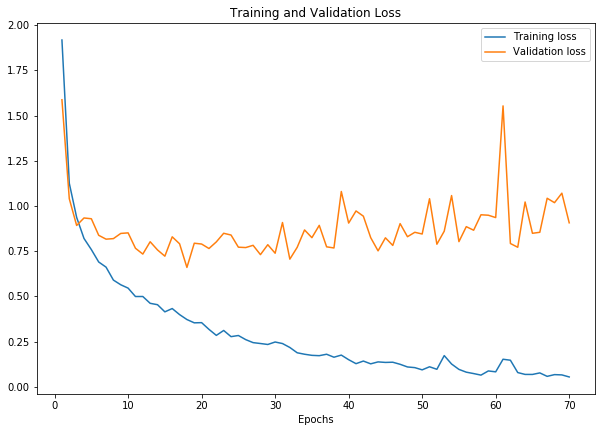

<Figure size 432x288 with 0 Axes>

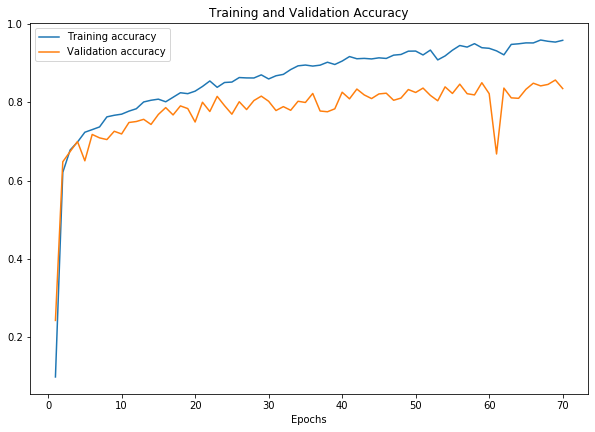

<Figure size 432x288 with 0 Axes>

In [38]:
# plt.plot(losses)
# plt.show()

epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## Test the network on the test data

We have trained the network over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  melanocytic nevi,   melanoma,   melanocytic nevi,   melanoma,   melanoma,   melanocytic nevi,   melanocytic nevi,   benign keratosis-like lesions,   basal cell carcinoma,   melanocytic nevi,  


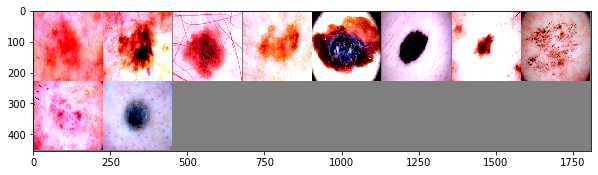

In [39]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

Okay, now let us check the performance on the test network:



In [40]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 85 %


In [41]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 92 %
Accuracy of basal cell carcinoma : 96 %
Accuracy of benign keratosis-like lesions : 92 %
Accuracy of dermatofibroma : 79 %
Accuracy of melanoma : 97 %
Accuracy of melanocytic nevi : 85 %
Accuracy of vascular lesions :  0 %


In [42]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
net.eval()
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 66 %
Accuracy of basal cell carcinoma : 77 %
Accuracy of benign keratosis-like lesions : 77 %
Accuracy of dermatofibroma : 69 %
Accuracy of melanoma : 79 %
Accuracy of melanocytic nevi : 88 %
Accuracy of vascular lesions :  0 %


### Confusion Matrix

In [44]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.numpy()

tensor([[6.0000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0200e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+00, 0.0000e+00, 2.0700e+02, 0.0000e+00, 5.0000e+00, 6.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+01, 1.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.1400e+02, 7.0000e+00,
         0.0000e+00],
        [3.0000e+00, 5.0000e+00, 3.8000e+01, 1.0000e+00, 1.7500e+02, 1.1190e+03,
         0.0000e+00],
        [0.0000e+00, 9.0000e+00, 1.0000e+00, 0.0000e+00, 8.0000e+00, 1.0000e+01,
         0.0000e+00]])


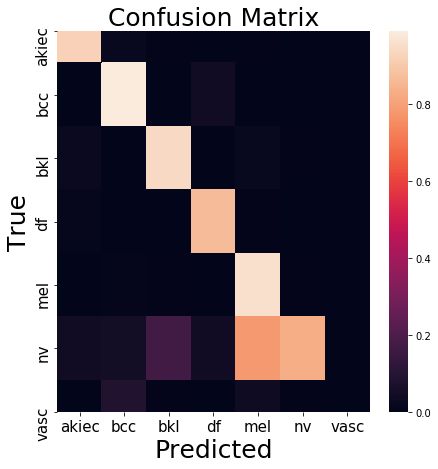

In [45]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);



### Grad cam

In [46]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

Generating Grad-CAM @layer4
	#0: melanocytic nevi (0.76489)


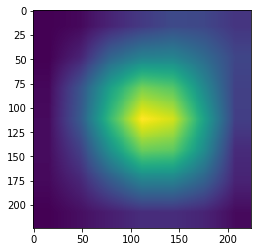

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  melanocytic nevi


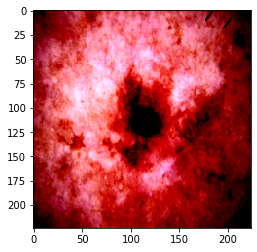

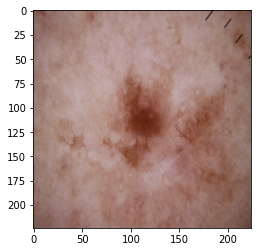

In [47]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["layer4"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()



# Conclusion

Training a neural network can be a daunting task, especially for a beginner. Here, are some useful practices to get the best out of your network.

- Training Ensembles — Combine learning from multiple networks.
- Always go for a lower learning rate.
- In cases of limited data try better augmentation techniques[20].
- Network architectures that have the appropriate depth for our problem — too many hyperparameters could lead to suboptimal results if we don’t have enough images.
- Improving loss function and class balancing.

In this tutorial we learned how to train a deep neural network for the challenging task of skin-lesion classification. We experimented with two network architectures and provided insights in the attention of the models. Additionally, we achieved 83% overall accuracy on HAM10000 and provided you with more tips and tricks to tackle overfitting and class imbalance.

Now you have all the tools to not only beat our performance and participate in the exciting MICCAI Challenges, but to also solve many more medical imaging problems.

Happy training!

 